# TCN Model on Lab p4679
Author: Camilla Billari <br> 
Date: 07/02/24

Fitting a TCN to the lab p4679 dataset.

In [4]:
# Import relevant libraries
import sys
import matplotlib.pyplot as plt
import numpy as np
import local_paths

# Change local path
sys.path.append(local_paths.MAIN_DIRECTORY)

# Import local modules - note: dependent on above path being set.
from utils.dataset import SlowEarthquakeDataset
from utils.nn_io import load_model, save_model
import scripts.general_functions as gfn
import scripts.tcn_oneshot_multistep as tcn

In [2]:
# Set random seed
SEED = 17 # random seed for the dataset and model
gfn.set_seed(SEED)

# Set torch device
device = gfn.set_torch_device()

No GPU available.


## Load Data

In [3]:
EXP = "p4679" # select Marone p4679 experiment

# Load dataset and convert to dataframe
dataset = SlowEarthquakeDataset([EXP])
df = SlowEarthquakeDataset.convert_to_df(dataset, EXP)

df.head()

,obs_shear_stress,obs_normal_stress,obs_ecdisp,time
0,5.091520,6.986740,22107.1104,0.000
1,5.090652,6.988410,22109.7823,0.001
2,5.089989,6.986299,22103.7900,0.002
3,5.089492,6.985970,22109.2161,0.003
4,5.088243,6.987547,22108.5900,0.004


In [6]:
# Select segment average and scale down by 10^8
shear_stress_df = df["obs_shear_stress"]

shear_stress_df.shape

(301721,)

## Data Pre-processing

### Denoising

In [7]:
# Data smoothing
SMOOTHING_WINDOW = 1 # moving average window size
DOWNSAMPLING_FACTOR = 50

# Smooth the data
df_smoothed = gfn.moving_average_causal_filter(shear_stress_df, SMOOTHING_WINDOW, DOWNSAMPLING_FACTOR)

df_smoothed.shape

(6034,)

In [8]:
# Check if smoothed results are statistically significantly different
results = gfn.compare_feature_statistics(shear_stress_df, df_smoothed)
print(results)

{'mean_comparison': {'t_statistic': -0.02370466572558935, 'p_value': 0.9810881997104777, 'significant': False}, 'variance_comparison': {'f_statistic': 0.0005619111772409071, 'p_value': 0.9810881993193293, 'significant': False}}


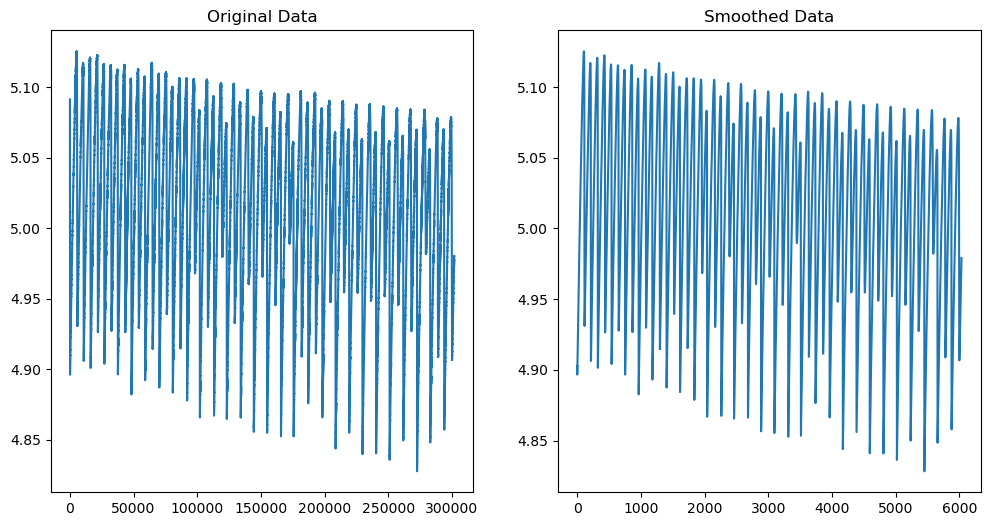

In [9]:
gfn.plot_original_vs_processed_data(shear_stress_df, df_smoothed, "line")

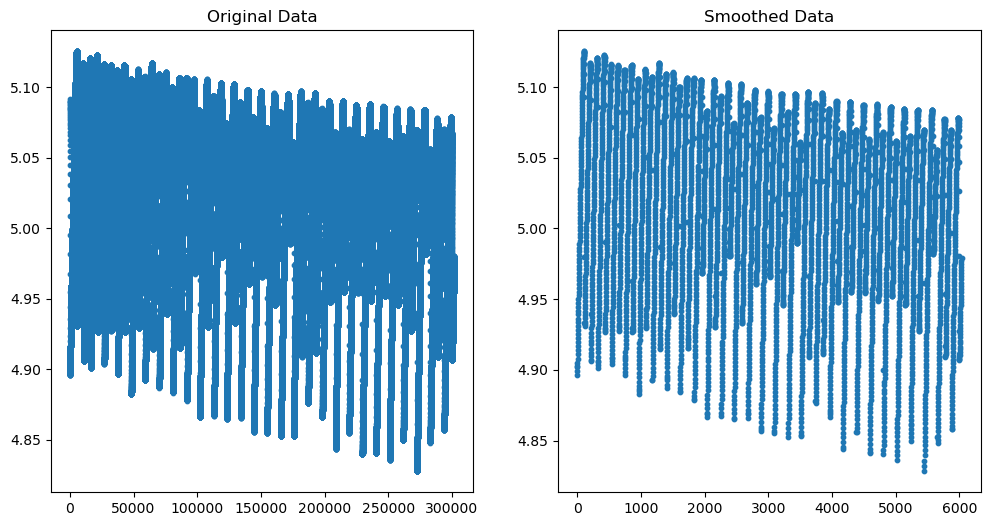

In [10]:
gfn.plot_original_vs_processed_data(shear_stress_df, df_smoothed, "scatter")

## Creating the datastet

In [11]:
# Dataset parameters
LOOKBACK, FORECAST = 80, 14 # lookback and forecast values
N_FORECAST_WINDOWS = 60 # n forecasted windows in test set

# Pre-process the data into windows
X, y = gfn.create_dataset(df_smoothed, LOOKBACK, FORECAST)

print(f"X and y shapes: {X.shape}, {y.shape}")

X and y shapes: torch.Size([5941, 80]), torch.Size([5941, 14])


In [12]:
# Split into train and test sets and normalise it
X_train, y_train, X_test, y_test = gfn.split_train_test_forecast_windows(X, y, FORECAST, N_FORECAST_WINDOWS)

# Display shapes of the created datasets
print(f"Training data shapes: {X_train.shape}, {y_train.shape}")
print(f"Testing data shapes: {X_test.shape}, {y_test.shape}")

Training data shapes: torch.Size([5096, 80]), torch.Size([5096, 14])
Testing data shapes: torch.Size([840, 80]), torch.Size([840, 14])


### Normalising with scaler based on the training set

In [13]:
# Normalise the dataset and save all sets into data_dict; keep scalers for later.
data_dict, scaler_X, scaler_y = gfn.normalise_dataset(X_train, y_train, X_test, y_test)

print(data_dict.keys())

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'X_train_sc', 'y_train_sc', 'X_test_sc', 'y_test_sc'])


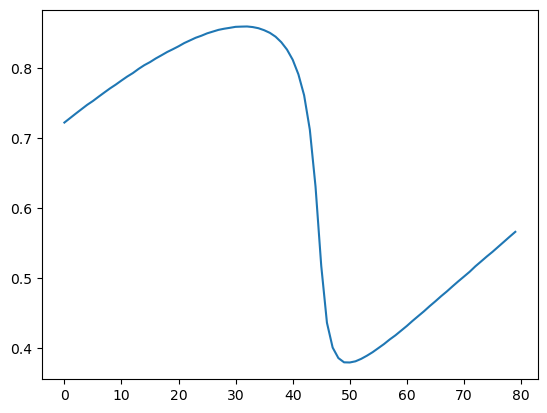

In [14]:
# Plot 3rd X_test window
plt.plot(data_dict["X_test_sc"][2, :])

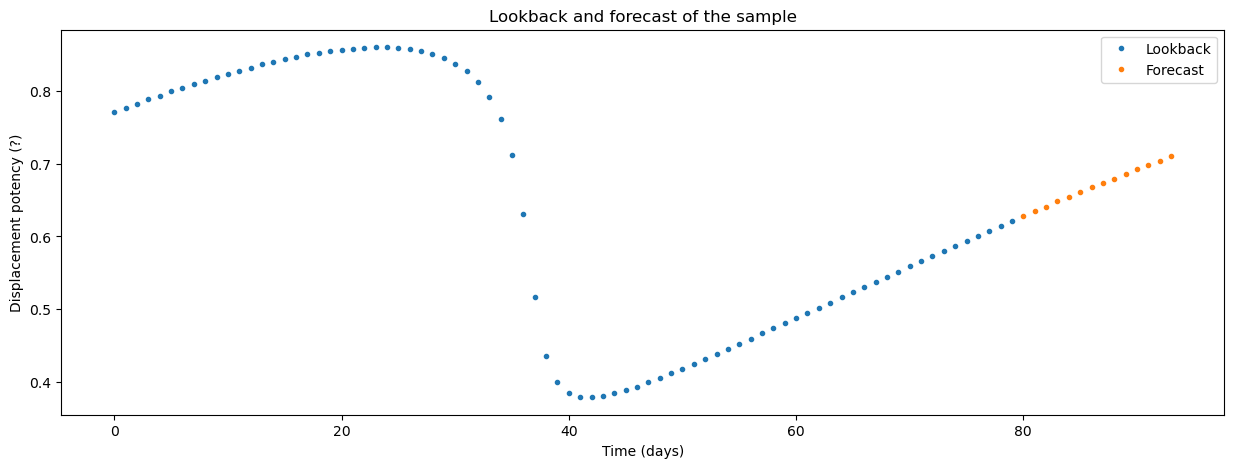

In [15]:
gfn.plot_example_sample(data_dict["X_test_sc"], data_dict["y_test_sc"], 10, LOOKBACK, FORECAST)

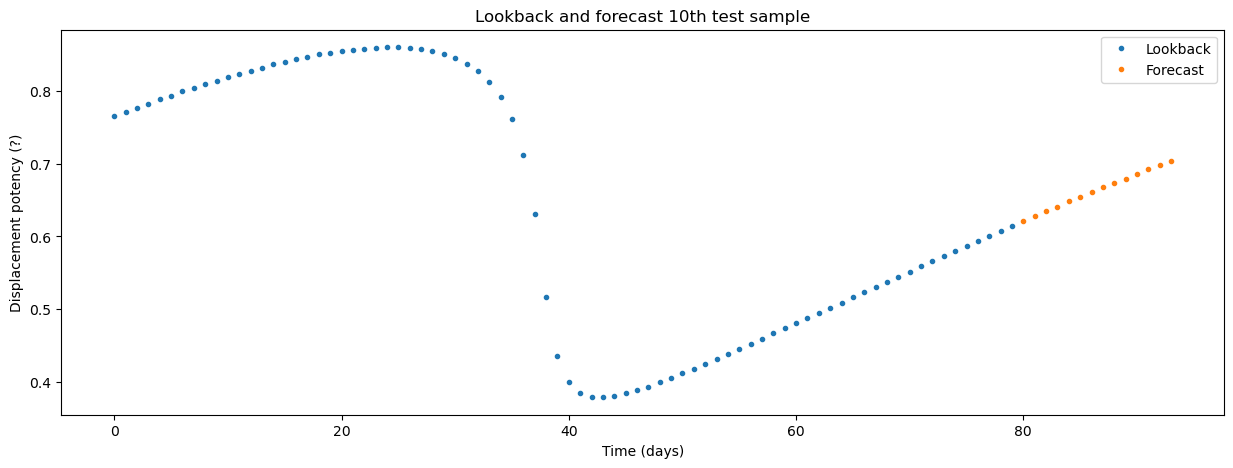

In [16]:
# Plot an example X and y sample
plt.figure(figsize=(15, 5))
plt.plot(data_dict["X_test_sc"][9], ".", label="Lookback")
# Plot the y sample shifted by the length of the lookback
plt.plot(np.arange(LOOKBACK, LOOKBACK + FORECAST), data_dict["y_test_sc"][9], ".", label="Forecast")
plt.title("Lookback and forecast 10th test sample")
plt.xlabel("Time (days)")
plt.ylabel("Displacement potency (?)")
plt.legend()
plt.show()

## Modelling

In [17]:
# For TCN config
N_VARIATES = 1
N_CHANNELS = [64, 64, 64, 64]
KERNEL_SIZE = 3
OUTPUT_SIZE = FORECAST

model = tcn.MultiStepTCN(N_VARIATES, N_CHANNELS, KERNEL_SIZE, OUTPUT_SIZE, device).to(device)

### Training

In [19]:
# For TCN training
N_EPOCHS = 75
results_dict = tcn.train_model(model, N_EPOCHS, data_dict, scaler_y, device)

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [75/75], Train RMSE: 0.0223, Test RMSE: 0.0264, Train R2: 0.8831, Test R2: 0.8321, Last Batch Loss: 0.0014: 100%|██████████| 75/75 [18:10<00:00, 14.53s/it]


## Results

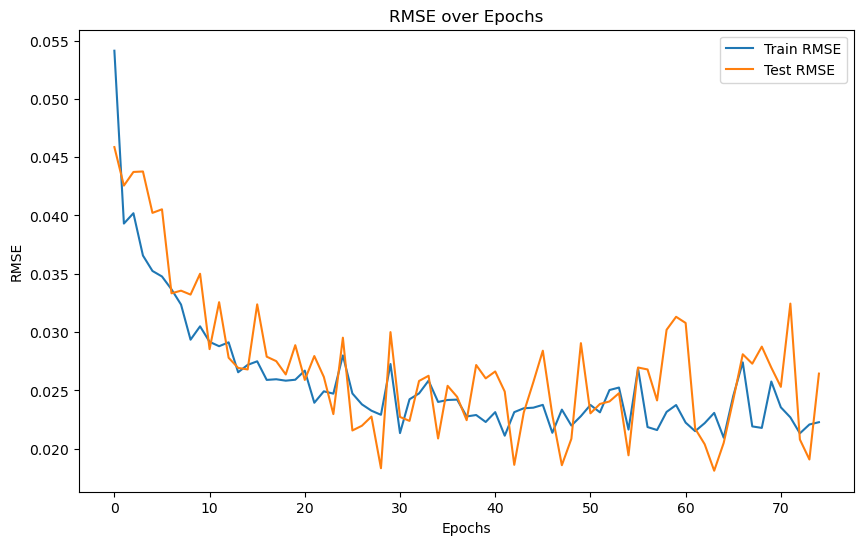

In [20]:
# Plot RMSE
gfn.plot_metric_results(N_EPOCHS, results_dict["train_rmse_list"], results_dict["test_rmse_list"], "RMSE")

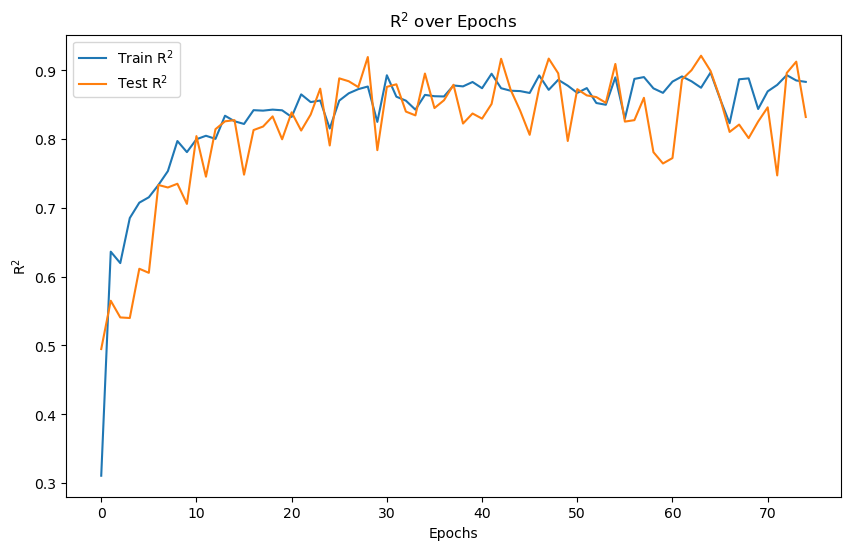

In [21]:
# Plot R2
gfn.plot_metric_results(N_EPOCHS, results_dict["train_r2_list"], results_dict["test_r2_list"], "R$^2$")

In [22]:
# Plot predictions against true values
TEST_START_IDX = len(df_smoothed) - len(y_test)
TITLE = "Original Time Series and Model Predictions of Segment 1 sum"
X_LABEL = "Time (days)"
Y_LABEL = "Displacement potency (?)"
ZOOM_MIN = 2600
ZOOM_MAX = 2800
ZOOM_WINDOW = [ZOOM_MIN, ZOOM_MAX]

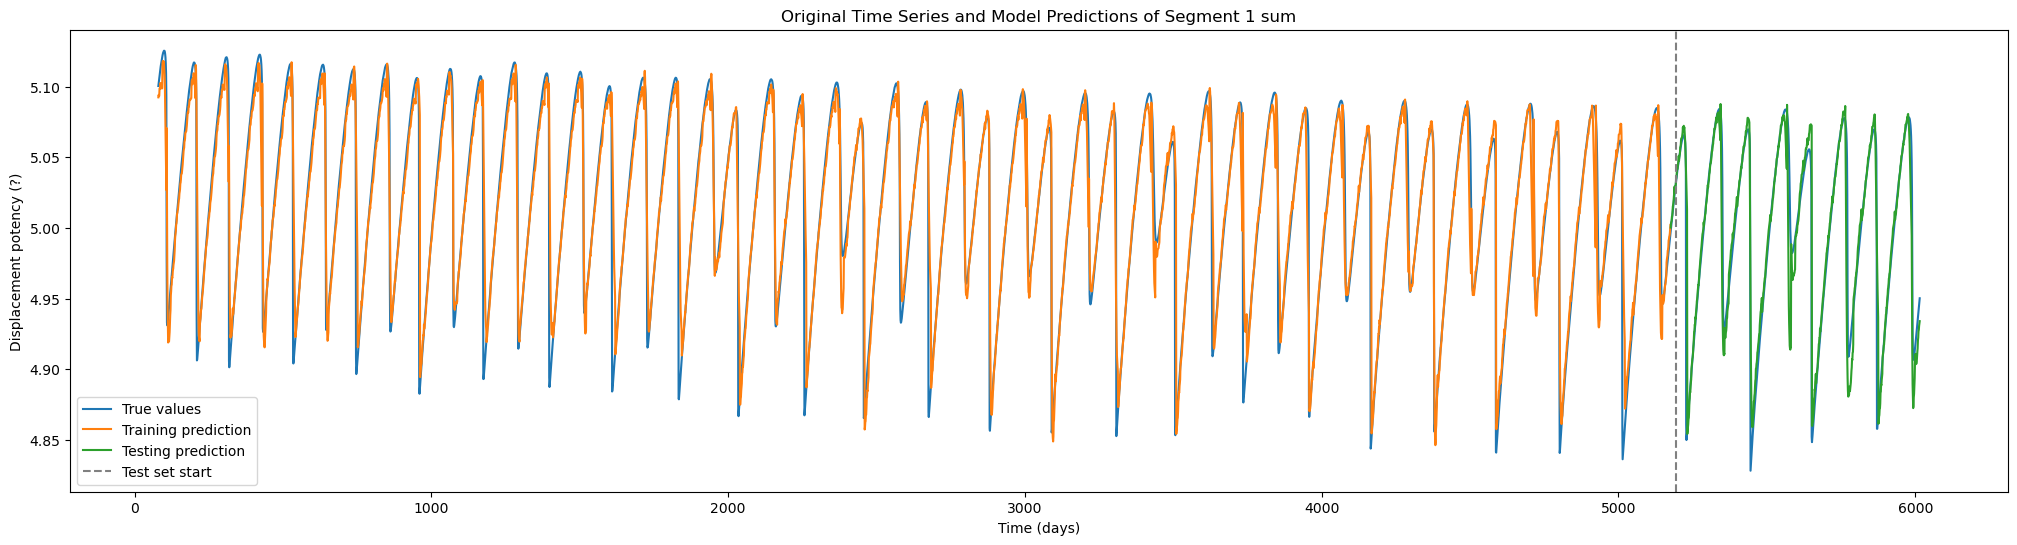

In [23]:
gfn.plot_all_data_results(TEST_START_IDX, data_dict, results_dict, LOOKBACK, FORECAST, TITLE, X_LABEL, Y_LABEL, [])


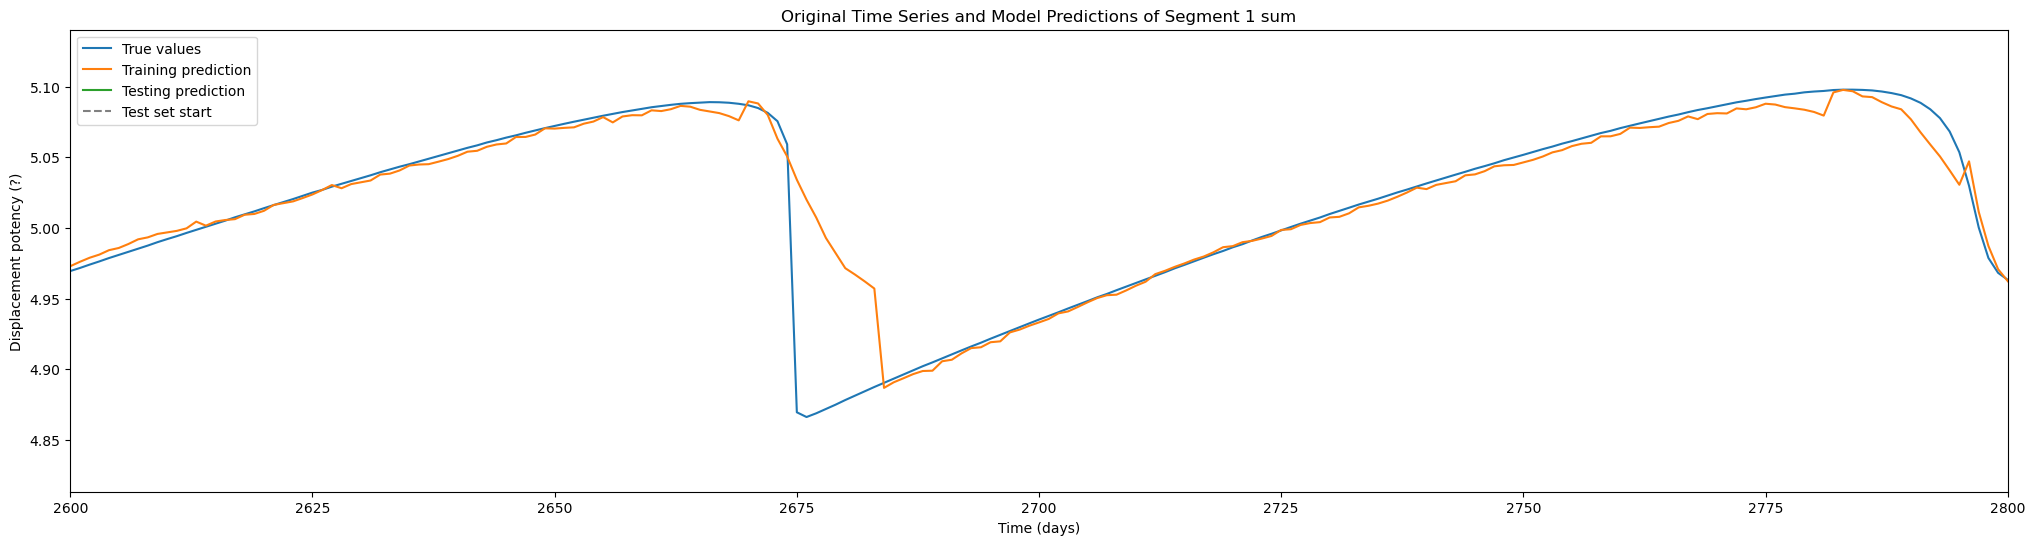

In [24]:
gfn.plot_all_data_results(TEST_START_IDX, data_dict, results_dict, LOOKBACK, FORECAST, TITLE, X_LABEL, Y_LABEL, ZOOM_WINDOW)
# LOOK AT BOKE